In [12]:
# %matplotlib nbagg
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import pickle
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import coloredlogs, logging
logger = logging.getLogger(__name__)
coloredlogs.install(level='CRITICAL', logger=logger)

import pymongo
from pymongo import MongoClient
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
import scipy
from bson.objectid import ObjectId
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime, UpdateDist, display_two_images
from controllers.learner.img2vec import NNFeatures
import controllers.learner.datasets as ds
from controllers.tests.hue_controller import HueLv2

mongo = MongoClient('localhost', 20202).hai
from flask import Flask
app = Flask(__name__)
app.config.from_pyfile(filename="application.cfg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


True

In [5]:
# pickle.dump(hue_lv2.X, open('X-1212-01.pkl', 'wb'))
# pickle.dump(hue_lv2.y, open('y-1212-01.pkl', 'wb'))
# X = pickle.load(open('X-08.pkl', 'rb'))
# y = pickle.load(open('y-08.pkl', 'rb'))
X = pickle.load(open('X-1212-01.pkl', 'rb'))
y = pickle.load(open('y-1212-01.pkl', 'rb'))

In [43]:
hue_lv2 = HueLv2('koki', debug=True, xy=(X, y))

In [44]:
hue_lv2.vectorize()


  2%|▏         | 18/1200 [00:04<04:42,  4.18it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


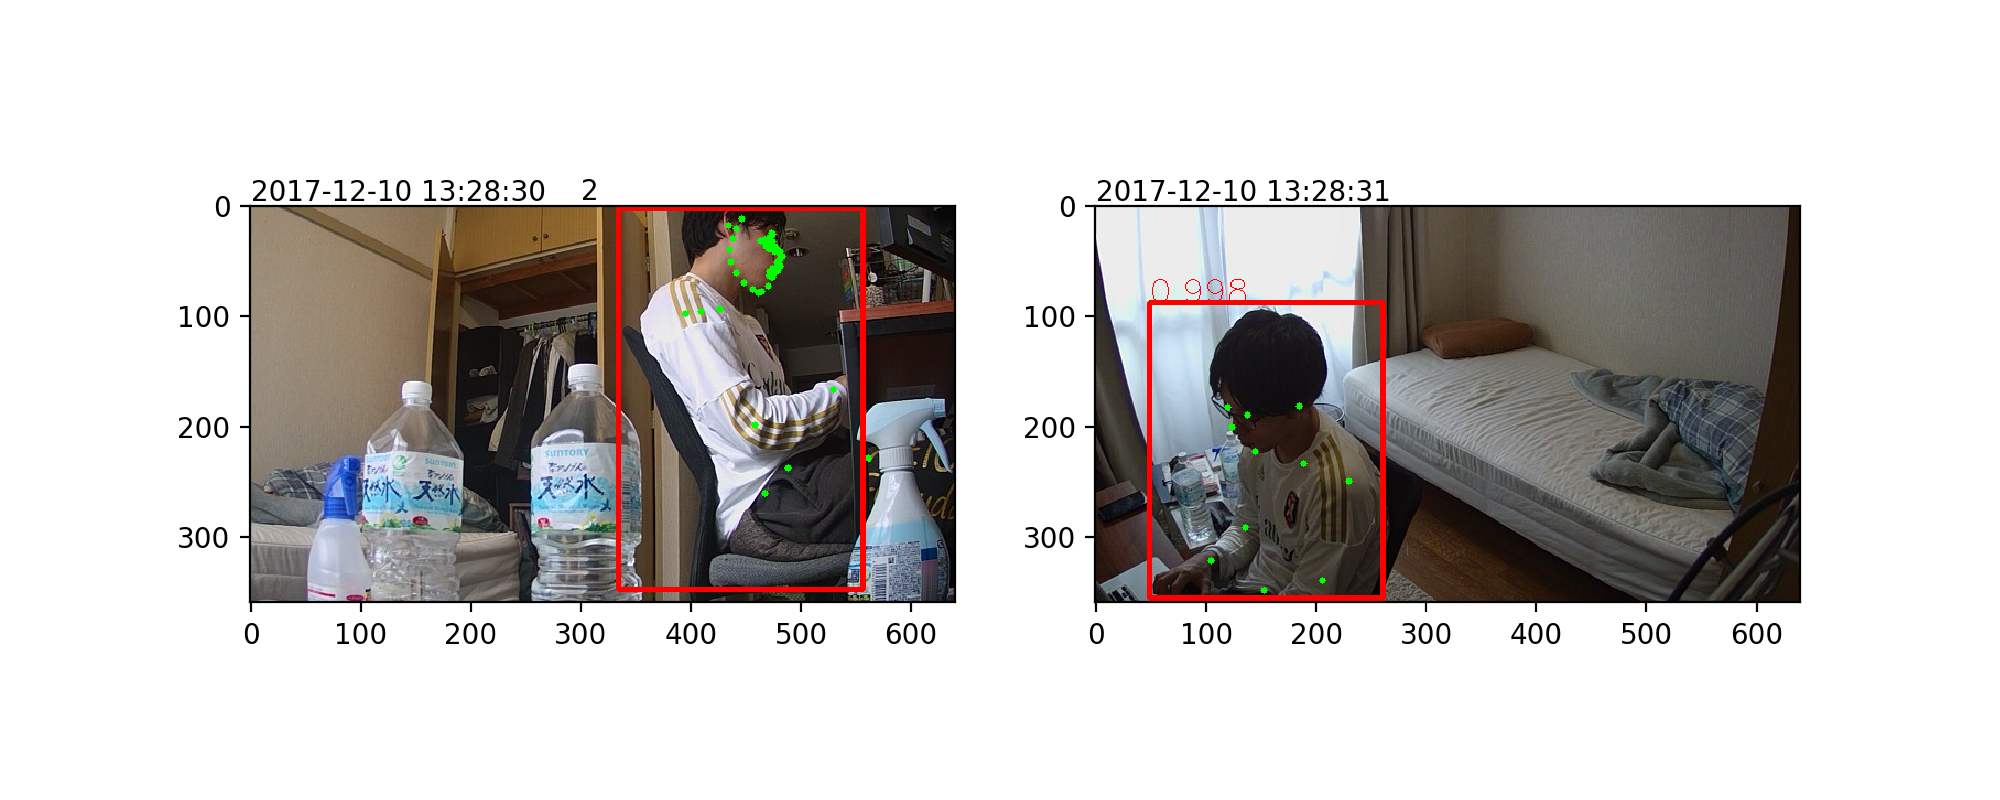

In [8]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, np.array(hue_lv2.X_cols), info=hue_lv2.labels, skip=2, pose=True, human=True)
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1210-05.mp4', writer="ffmpeg")
fig.show()

In [42]:
clf = RandomForestClassifier()
# clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])

# y is invalid.
np.mean(cross_validation.cross_val_score(pipe, hue_lv2.X, hue_lv2.y, cv=5))

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.75583333333333336

In [45]:
train_test_split(hue_lv2.X_cols, hue_lv2.labels, train_size=0.6, random_state=1)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [35]:
indices = np.arange(len(hue_lv2.X_cols))
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(hue_lv2.X, hue_lv2.y, indices, train_size=0.6, random_state=1)
pipe.fit(X_train, y_train)
cols_val = np.array(hue_lv2.X_cols)[indices_val]
prediction = pipe.predict(X_val)
info =['truth: '+str(a)+', predict: '+str(b) for a, b in zip(y_val, prediction)]

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
high_probs = np.where(prediction.max(axis=1) > 0.8)
indices_high_probs = indices_val[high_probs]
prediction = pipe.predict_proba(X_val)[high_probs]
cols_val = np.array(hue_lv2.X_cols)[indices_high_probs]

AxisError: axis 1 is out of bounds for array of dimension 1

In [37]:
info =['truth: '+str(a)+', predict: '+str(b) for a, b in zip(y_val, prediction)]

<IPython.core.display.Javascript object>


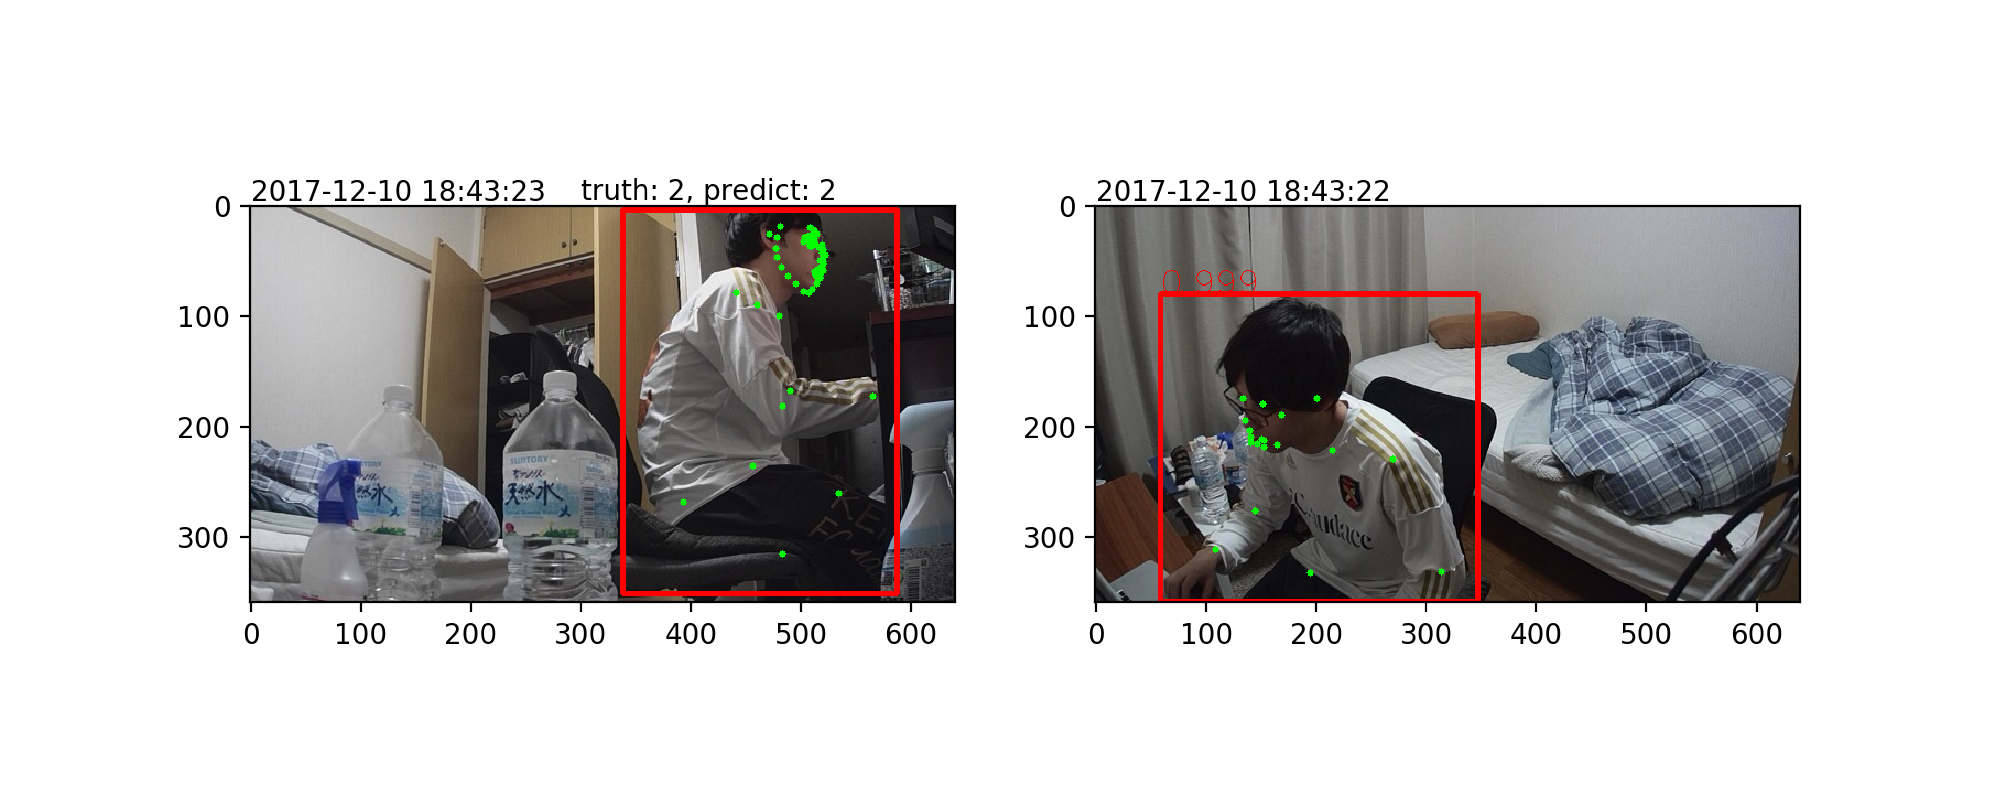

In [38]:
%matplotlib nbagg
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, cols_val, info=info, pose=True, human=True)
ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
ani.save('1217-01.mp4', writer="ffmpeg")
# fig.show()